# Pima KNN 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import time as time
from matplotlib import pyplot as plt
import sys
sns.set()
from tqdm import tqdm

#import dataset
diabetes_data = pd.read_csv('diabetes.csv')

## Dataset Details

From the visualizatons I noted a significant imbalance between outcome 0 and 1. As for the features, the data set skews toward young people with few children, mid-low blood pressure who are obese. In order to get a better sense of which features are correlated with Diabetes I outputted a correlation matrix, which shows that blood pressure and skin thickness have little relevance to our dependent variable. 

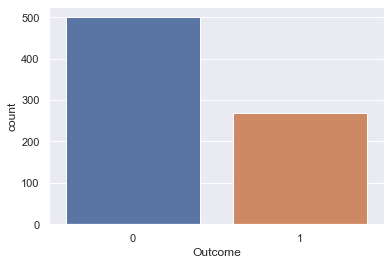

In [2]:
#How balanced is my dataset for those who have diabetes and those who don't?
ax = sns.countplot(x='Outcome',data=diabetes_data)

In [3]:
#is all my data numerical and therefore useful? --> Yes
diabetes_data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [4]:
#what are the range of values for each feature and should they be normalized? --> Yes
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


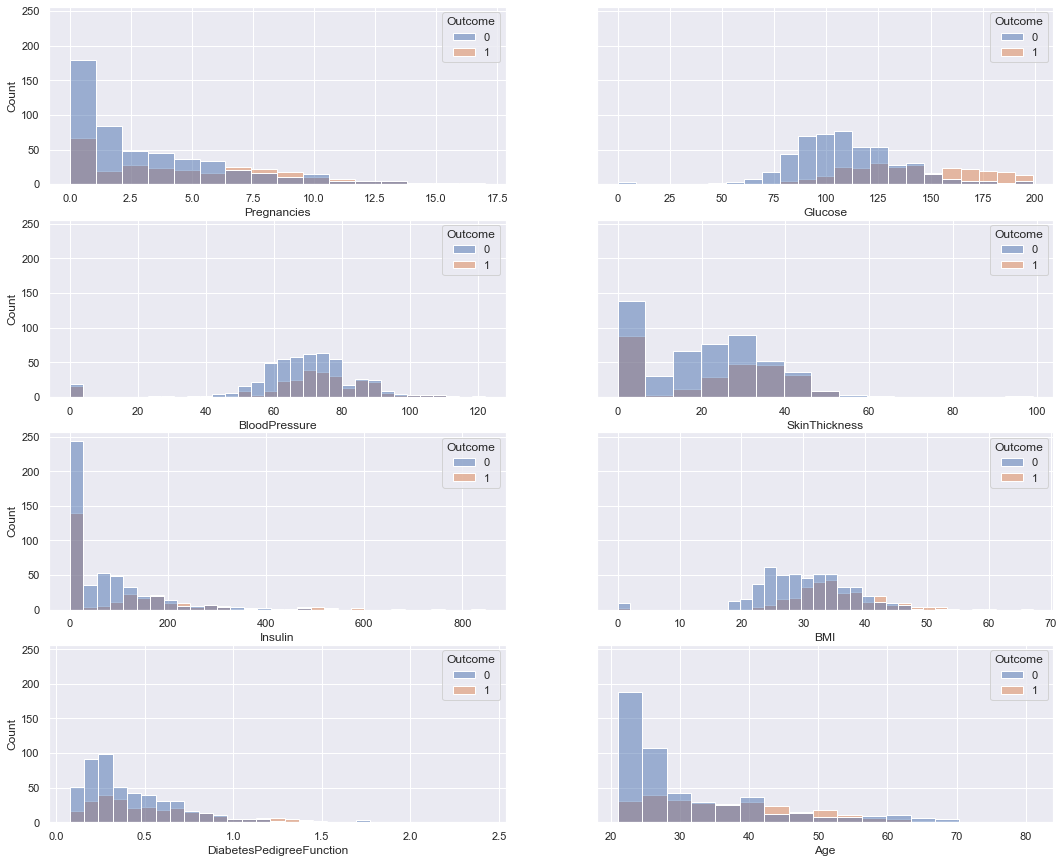

In [5]:
#What are the distributions for every feature?
def showHistograms(data):
    fig, axes = plt.subplots(4,2, figsize=(18,15), sharey=True)


    sns.histplot(ax=axes[0][0], data = data, x='Pregnancies', hue='Outcome')
    sns.histplot(ax=axes[0][1], data = data, x='Glucose', hue='Outcome')
    sns.histplot(ax=axes[1][0], data = data, x='BloodPressure', hue='Outcome')
    sns.histplot(ax=axes[1][1], data = data, x='SkinThickness', hue='Outcome')
    sns.histplot(ax=axes[2][0], data = data, x='Insulin', hue='Outcome')
    sns.histplot(ax=axes[2][1], data = data, x='BMI', hue='Outcome')
    sns.histplot(ax=axes[3][0], data = data, x='DiabetesPedigreeFunction', hue='Outcome')
    sns.histplot(ax=axes[3][1], data = data, x='Age', hue='Outcome')
    
showHistograms(diabetes_data)





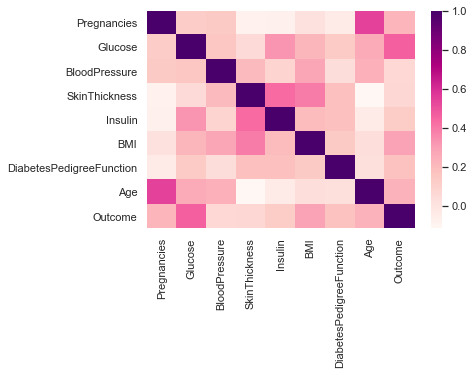

In [6]:
#What features are strongly correlated to label, and which arent?

ax = sns.heatmap(diabetes_data.corr(), cmap='RdPu')


## Train-Test Split 

Because our data set is heavily imbalanced, I want to make sure that the model doesn't have a bias toward class 0. Furthermore it's not clear which K i should use for this binary classifcation problem, which means we need hyperparameter tuning. Therefore, I split the data into training and validation/testing. Merging the testing and validation data set allowed me to maximize the size of a balanced training set. Ideally, this should better enable the training data to [capture the generalized trends of the data](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/). The result is a 52%/48% split between training and testing, with the training set having 200 random samples for each outcome and the for testing/validation set having 300/60 for testing. 

In [7]:
def train_test_split(col_to_group, data, sample_size):
    
    #for loop through every group and sample, generate concatenated dataframe calling train
    grouped_data = data.groupby([col_to_group])
    train = pd.DataFrame()

    for label, group in grouped_data:
        train = pd.concat([train,group.sample(n=sample_size)])
    
    #get left only using original data and concatenated data.
    
    test = data.merge(train, how='left', indicator=True)
    test = test[test['_merge'] == 'left_only']
    test_label = test[col_to_group]
    test.drop(columns=['_merge',col_to_group], inplace=True)
  
    
    
    return (train,test,test_label)



## Algorithm Description

### Preprocessing
In the data visualization section I discovered that skin thickness and blood pressure have the weakest relationship with the outcome variable. They would do little in helping our classifcaiton and were therefore removed from both training and testing sets. I also normalized each data set since the distance function for KNN is sensitive to the scale of each feature. It's important to note that I normalized after partitioning the data to [avoid data leakage](https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742). I also removed all duplicates in both datasets. 

In [8]:
#Normalize data due to scaling differences acrosss features, 
def preprocess_data(train, test):
    
    train.drop_duplicates(inplace=True)
    test.drop_duplicates(inplace=True)
    
    test.drop(columns=['SkinThickness','BloodPressure'], inplace=True)
    train.drop(columns=['SkinThickness','BloodPressure'], inplace=True)
    
    for column in train:
        if(column == 'Outcome'):
            break
        train[column] = ((train[column]-train[column].min())/(train[column].max() - train[column].min()))
        test[column] = ((test[column]-test[column].min())/(test[column].max() - test[column].min()))
    
    return (train,test)

In [57]:
class KNN:
    
    
    def __init__(self, data, k, func): #input is training set,k-value, and distance metric
        self.data = data
        self.k = k
        self.dist_arr = []
        self.func = func
        
    
    
    def getDistance(self, x1, x2):
        
        return self.func(self,x1,x2)
            
    
    #return sorted dataframe of neighbors using training set and test point
    def getNeighbors(self, test_pt):
        #for each training point, get distance, store in array along with label
        for i, row in self.data.iterrows():
            label, dist = self.getDistance(test_pt, row)
            self.dist_arr.append({"label":label, "distance": dist})
        
        
    
    #use sorted dataframe to return the averge label of the k^th elements
    def predict(self, test_pt):
        self.getNeighbors(test_pt)
        sorted_arr = sorted(self.dist_arr,key = lambda i: i['distance']) #sort by distance
        self.dist_arr = []
        #print(sorted_arr)
        
        total = {'0':0, '1': 0, '2':0, '3':0, '4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
        
        for i in range(0,self.k):
             total[str(int(sorted_arr[i]['label']))] += 1
            
           
        return int(max(total, key=total.get))
            



### Hyperparameters

To find the best model three distance metrics were used: [Euclidean, Hamiltonian, and Cosine](https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html). I also tested k values of 3 and 5. for each distance metric. 

In [10]:
def get_e_distance(self, x1,x2):
    #seperate label from the rest 
    label = ''
    row = ''
    if 'Outcome' in x2.index:
        label = x2['Outcome']
        row = x2.drop(labels='Outcome')  
    if 'label' in x2.index:
        label = x2['label']
        row = x2.drop(labels='label')

    row = x1 - row 

    row = row.pow(2) 

    dist = row.sum() 


    return (label,sqrt(dist)) 

In [11]:
def get_m_distance(self, x1,x2):
    label = ''
    row = ''
    if 'Outcome' in x2.index:
        label = x2['Outcome']
        row = x2.drop(labels='Outcome')  
    if 'label' in x2.index:
        label = x2['label']
        row = x2.drop(labels='label')
        #print('in label')
   
    row = x1 - row
   
    row = row.abs()
    
    dist = row.sum()
    return (label, dist)

In [12]:
def get_c_distance(self,x1,x2):
    label = ''
    row = ''
    if 'Outcome' in x2.index:
        label = x2['Outcome']
        row = x2.drop(labels='Outcome')  
    if 'label' in x2.index:
        label = x2['label']
        row = x2.drop(labels='label')
    num = row.dot(x1) 
    denom = sqrt(row.dot(row)) * sqrt(x1.dot(x1))
    return (label, 1 - (num/denom))
    
    

In [13]:
def measure_performance(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    index = 0
    for _,row in y_actual.items():
        if((row == 1) and (y_pred[index] == 1)):
            TP+=1
        if((row == 0) and (y_pred[index] == 0)):
            TN+=1
        if((row == 1) and (y_pred[index] == 0)):
            FN+=1
        if((row == 0) and (y_pred[index] == 1)):
            FP+=1
        index+=1
    return (TP, FP, TN, FN)
        
      
    

In [58]:
def measure_performance_images(y_actual, y_pred):
   # F0, T0, F1, T1, F2, T2, F3, T3, F4, T4, F5, T5, F6, T6, F7, T7, F8, T8, F9, T9 
    metrics = [[0 for i in range(10)] for j in range(10)]
    index = 0
    for _,row in y_actual.items():
        metrics[row][y_pred[index]] += 1
        index+=1
    return metrics
        
      

## Algorithm Results

In [14]:
def train_build_eval(k, distance_func, train, test, test_label):
    
    model = KNN(data = train, k = k, func = distance_func) #train model 
   
    y_pred = []
    curr = time.time()
    index = 0
    with tqdm(total=len(test)) as pbar:
        for i, row in test.iterrows():  
            #print('predicting {} row'.format(index))
            y_pred.append(model.predict(row)) #gets predictions
            pbar.update(1)
            index += 1
    post = time.time()
    return ((post-curr) * 1000, measure_performance(test_label,y_pred)) #measure performance

In [59]:
def train_build_eval_images(k, distance_func, train, test, test_label):
    
    model = KNN(data = train, k = k, func = distance_func) #train model 
   
    y_pred = []
    curr = time.time()
    index = 0
    with tqdm(total=len(test)) as pbar:
        for i, row in test.iterrows():  
            #print('predicting {} row'.format(index))
            y_pred.append(model.predict(row)) #gets predictions
            pbar.update(1)
            index += 1
    post = time.time()
    return ((post-curr) * 1000, measure_performance_images(test_label,y_pred)) #measure performance

### Model Performance

The results show that the model is accurate ~70% of the time and with a ~90% precision value for negative. However, the model too frequently labels positive incorrectly, resulting in a precision of ~38% for positive. This is likely a consequence of undersampling the negative labels, causing larger decision boundaries for positive values that would've been minimized with the introduction of more negative samples in the training data. In terms of distances metrics, the best one was Manhattan with k=3. It does not surprise me because manhattan performs better when the [features are dissimilar](https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/). However, increasing k allows the model to have [smoother decision boundaries rather than having lots of variance due to the training data](https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/), which can decrease the chances of erroneously labeling due to random, minute clusters of data. As a result I expected the higher value of k to perform better. If we ran multiple trials and averaged the metrics for each scenario, we may see k=5 outperform k=3 for Manhattan distance. The average time in milliseconds was about 12,000, which equates to 2 minutes. This is to be expected due to the gerneral slowness of the searching through the entire training set for every test entry and sorting the result. 

In [23]:
distance_metrics = [get_e_distance, get_m_distance, get_c_distance]
result = pd.DataFrame(columns=['K-value','Distance_Metric', 'TP', 'FP','TN', 'FN', 'time(ms)'])
distance_names = ['Euclidean', 'Manhattan', 'Cosine']
for i,get_distance in enumerate(distance_metrics):
    for k in range(3,6,2):
        train,test, test_label = train_test_split('Outcome', diabetes_data, 200 ) #get training and testing data set  
        train, test = preprocess_data(train, test) #clean, seperate label from test data
        t, metrics = train_build_eval(k, get_distance, train, test, test_label)
        result = result.append({'K-value': k, 'Distance_Metric': distance_names[i], 'TP': metrics[0], 'FP': metrics[1], 'TN': metrics[2], 'FN':metrics[3], 'time(ms)':t}, ignore_index=True)
result

,K-value,Distance_Metric,TP,FP,TN,FN,time(ms)
0,3,Euclidean,48,96,204,20,149042.344809
1,5,Euclidean,55,121,179,13,141827.059031
2,3,Manhattan,48,77,223,20,118022.796631
3,5,Manhattan,47,114,186,21,123266.092777
4,3,Cosine,43,121,179,25,103954.514980
5,5,Cosine,44,109,191,24,108294.782162


# MNIST KNN

In [15]:
#import kaggle data set

data = pd.read_csv('/Users/vishesh.javangula@ibm.com/Downloads/train.csv')

## Datset Details

Through our visualizations I can see how the images resemble handwriting rather than digital fonts. As a result I expect some error in our predictions due to the variances in human handwriting. Furthermore the footprint of the actual written number on the 28x28 canvas vary in size. This will infleunce my features selection process, or lack thereof, due to needing all 28^2 pixels. In terms of balance, I noted that we have significanlty fewer labels for digit '5' than others. 

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


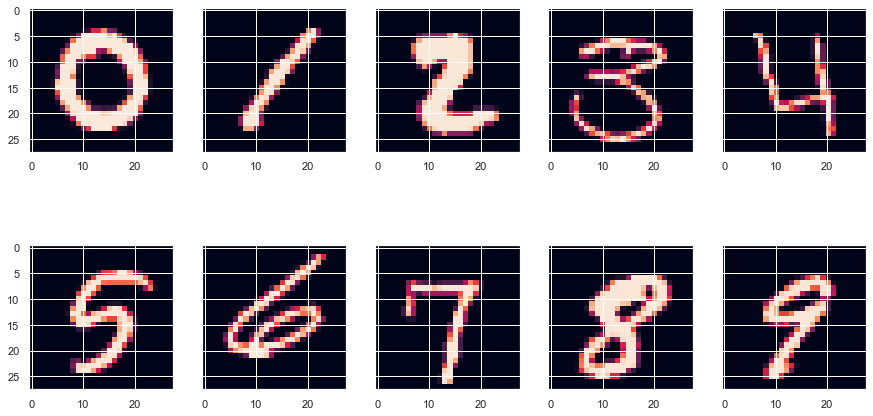

In [25]:
#Visualization
from PIL import Image as im
fig, ax = plt.subplots(2,5, figsize=(15,8), sharey=True)
grouped_images = data.groupby(['label'])

for j, group in enumerate(grouped_images):
    labels, values = group
    values.drop(columns=['label'], inplace=True)
    num = values.iloc[0].to_numpy()
    num = np.reshape(num,(28,28)) #converts to correct dimensions
    ax[int(j/5)][j % 5].imshow(num)

In [63]:
data.shape

(42000, 785)

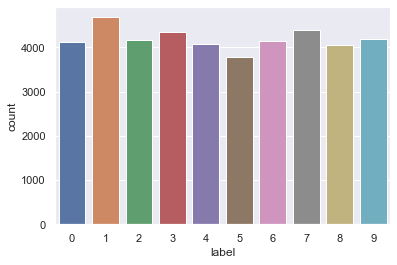

In [26]:
#How balanced is my dataset?
ax = sns.countplot(x='label', data=data)

## Algorithm Description
Because the metric for each feature is the same, there is no point in normalizing data. Furthermore we cannot employ dimesionality reduction as every pixel is needed to recreate the image. Therefore the only preprocessing I did was remove duplicates. However, I did only use a subsample of the dataset as the slowness of KNN would result in the algorithm taking 3-4 days to finish. I decided to sample 500 rows from each label for a total dataset size of 5,000. Using this balanced dataset I implemented a typical 70/30 split while ensuring that the training and testing dataset still had a uniform distributions of labels. I also used hyperparamter tuning for k-values to find the optimal model. The training set will be randomly sampled to ensure honest hyperparameter analysis. Because the range of each feature is similar I decided to use Euclidean distance as [it is known to perform better in these scenarios](https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/). The results are shared via confusion matrix. 

I also measured the effect of k on model accuracy by only testing label 0 on my training data. Euclidean distance was used in order to get the highest accuracy possible.

In [76]:
data.drop_duplicates(inplace=True)

In [77]:
#subset of data
sub_data = pd.DataFrame()
for label, group in data.groupby(by='label'):
        sub_data = pd.concat([sub_data,group.sample(n=500)])

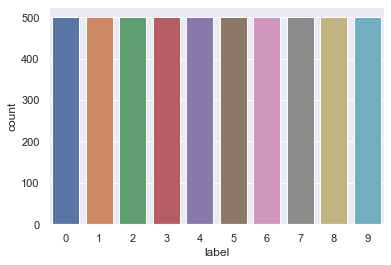

In [78]:
ax = sns.countplot(x='label', data=sub_data)

In [83]:
sub_data.shape

(5000, 785)

### Algorithm Results

The two confusion matrices below show the results when k=3 and k=5. While the performances are similar, k=3 appears to be perform better than k=5. This may be because k=5 overgeneralized the decision boundaries, causing an increase in error. Similar to the diabetes results, these results reflect the scores for a single trial of both k-values. Averaging over multiple k-values may reveal a different relationship than what we see now. Both models had trouble identifying label 4 correctly and mistook it as 9. This is unsurprising as both strokes may appear similar when analyzing handwritten numbers. Both models also struggled classifying 8 and mistook for 5, 3, and 1. 5 and 3 are to be expected due to their general shape but 1 is unusual. It could be that some images have a narrowly written 8, which then start to resemble 1. 

The change in accuracy in identifying label 0 as a function of k shows us that k=3 is the optimal hyperparameter. As mentioned earlier, increasing k smoothens the decision boundary, which can lead to increases in error. On the other hand having too small of a k value can make labels highly influenced by noise and produce erroneous results. k=3 struck a balance and produced an accuracy of 100% for identifying 150 values. 

Due to having a relatively large training and test set, the confusion matricies each took over an hour to produce and the accuracy scores for label 0 took ~8 minutes for each value of k. The average iteration rate was 3.25s, which  means that it took roughly 3.25 seconds to predict the label of a single test point.   


100%|██████████| 1500/1500 [1:24:38<00:00,  3.39s/it]


time to compute when k=3 is 5078408.633232117 ms


100%|██████████| 1500/1500 [1:21:10<00:00,  3.25s/it]


time to compute when k=5 is 4870312.37912178 ms


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


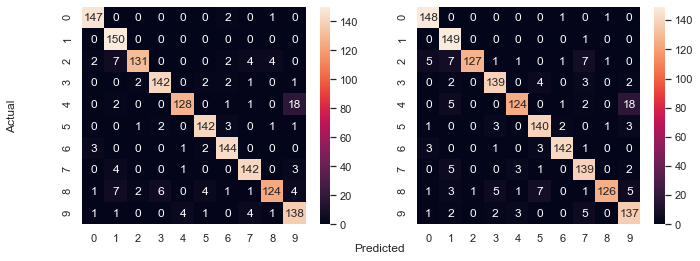

In [79]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
fig.text(0.5, 0.03, 'Predicted', ha='center')
fig.text(0.03, 0.5, 'Actual', va='center', rotation='vertical')
np.array
distance_names = ['Euclidean', 'Manhattan', 'Cosine']

index = 0
for k in range(3,6,2):
    train,test, test_label = train_test_split('label', sub_data, 350 ) #get training and testing data set  
    t, metrics = train_build_eval_images(k, get_e_distance, train, test, test_label)
    sns.heatmap(np.asarray(metrics), annot=True, fmt="d", ax=ax[index] )
    print('time to compute when k={} is {} ms'.format(k,t))
    index+=1
fig.show()


In [80]:
def get0label(test,test_label):
    test['label'] = test_label
    test = test.groupby(by='label').get_group(0)
    test_label = test['label']
    test.drop(columns='label', inplace=True)
    return (test,test_label)

In [84]:
# TODO: Choose a single digit to measure accuracy and vary k
result = pd.DataFrame(columns=['label','K-value', 'Accuracy','time(ms)'])
distance_names = ['Euclidean', 'Manhattan', 'Cosine']

for k in range(1,6,2):
    train,test, test_label = train_test_split('label', sub_data, 350) #get training and testing data set  
    test, test_label = get0label(test, test_label) # gets test values with true label of 0
    t, metrics = train_build_eval_images(k, get_e_distance, train, test, test_label)
    result = result.append({'label': 0, 'K-value': k, 'Accuracy': metrics[0][0]/np.sum(metrics[0]), 'time(ms)': t}, ignore_index=True)
result




/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
100%|██████████| 150/150 [07:42<00:00,  3.09s/it]


,label,K-value,Accuracy,time(ms)
0,0.0,1.0,0.986667,496721.596003
1,0.0,3.0,1.000000,481812.942982
2,0.0,5.0,0.973333,462815.742970


### Time Complexity:

Given N total samples in our data set we use cN was used for training and dN for testing. For each point in the test set, we have to calcualte the dsitance to cN training points by leveraging M features. Finally we have to sort the list of distances. Overall our TC is (dN * cN * M) + N^2 == O(N^2). If we were to calcualte on an individual bases, then we have O(N*M) = O(N) if N >> M

# Sources

1. https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/
2. https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
3. https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html
4. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
